# Analysis of samples from analysis_random_v3.csv file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "csvs/recursively_generated_grids_1.csv"
df = pd.read_csv(filepath, sep=";")

df_filtered = df[df["number_of_steps_to_solve"] != -1]


C:\Users\adria\AppData\Local\Temp\ipykernel_14572\1044353323.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Valid/total ratio

In [2]:
ratio = len(df_filtered) / len(df)
print(f"{ratio * 100:.2f}%")


100.00%


## Multiple regression analysis

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump


x = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']]
y = df_filtered["number_of_steps_to_solve"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

dump(model, "sudoku_model.joblib")

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

print("Coefficients:", model.coef_)


Mean Squared Error: 116.90841051308882
Coefficient of Determination (R^2): 0.24556135398338808
Coefficients: [ 0.16459166 -0.36828622  5.09821377]


## Correlation test

In [5]:
correlation_matrix = df_filtered.corr()
correlation_matrix.iloc[-1][:-1]

sudoku                     -0.052447
sum_of_candidates           0.493633
number_of_initial_values   -0.485801
initial_numbers_entropy    -0.106622
Name: number_of_steps_to_solve, dtype: float64

## Predictors vs number_of_steps (plots)

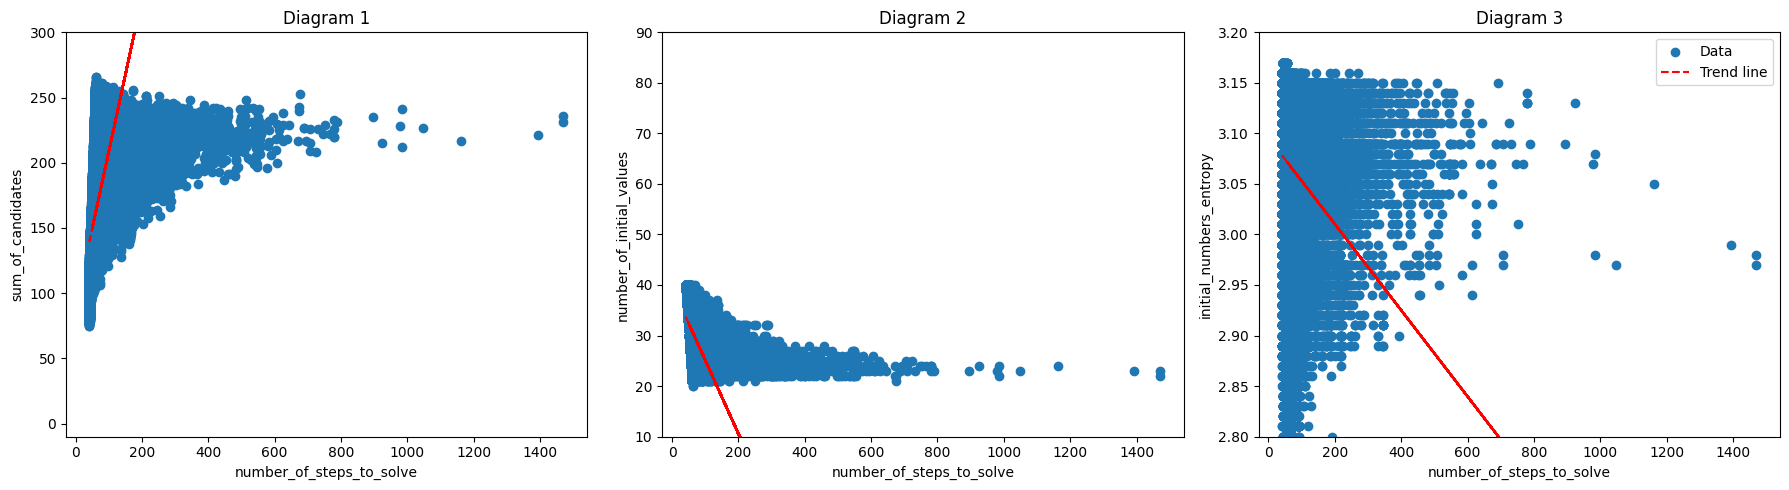

In [7]:
plt.figure(figsize=(18, 5))

columns = ['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']

for i, column in enumerate(columns, 1):
    x = df_filtered['number_of_steps_to_solve']
    y = df_filtered[column]
    
    plt.subplot(1, 3, i)
    plt.scatter(x, y, label='Data')
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend line')
    
    plt.title(f'Diagram {i}')
    plt.xlabel('number_of_steps_to_solve')
    plt.ylabel(column)
    ax = plt.gca()
    
    if i == 1:
        ax.set_ylim([-10, 300])
    elif i == 2:
        ax.set_ylim([10, 90])
    else:
        ax.set_ylim([2.8, 3.2])


plt.tight_layout()
plt.legend()
plt.show()

## Distribution of grids based on number of initial values, splitted into valid and invalid grids (plot)

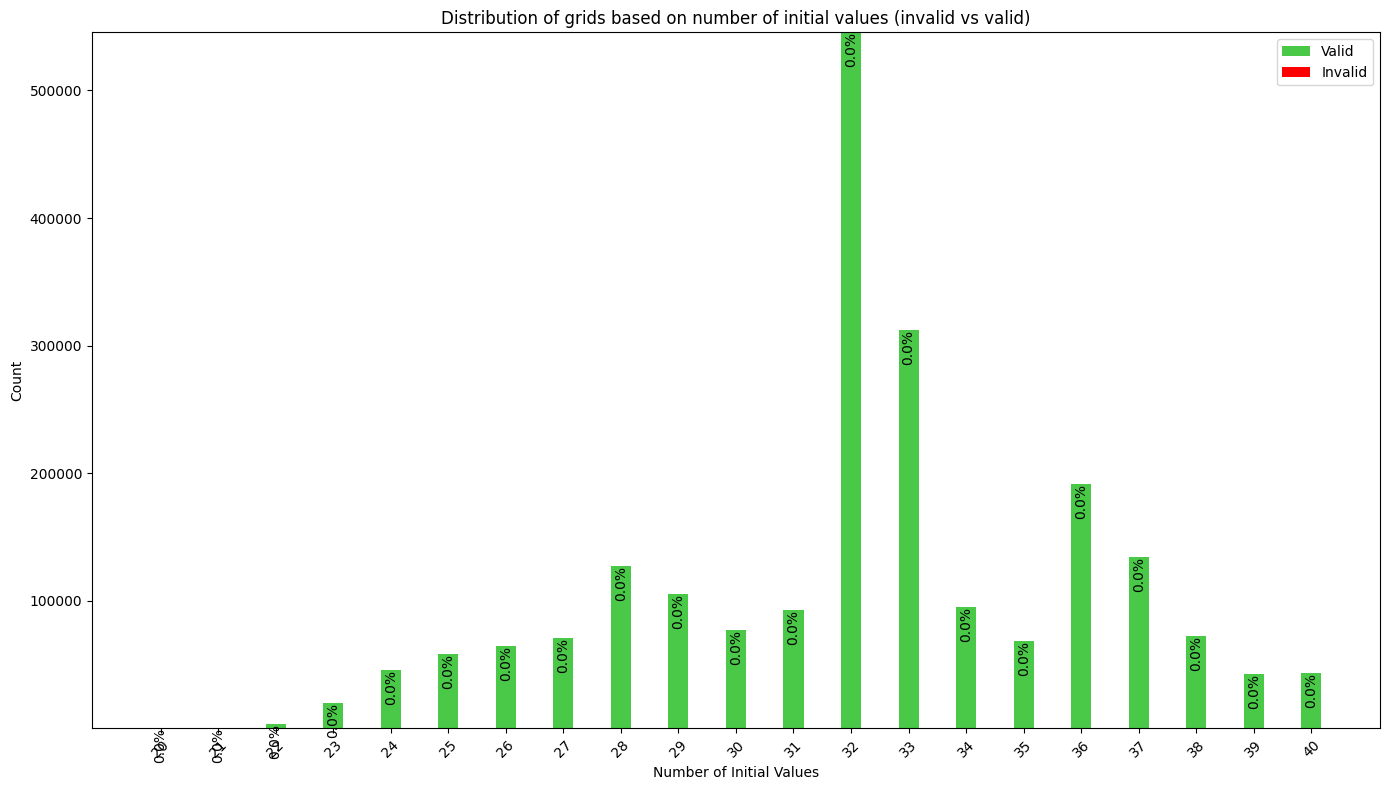

In [8]:
df['is_valid'] = df['number_of_steps_to_solve'] != -1

grouped = df.groupby('number_of_initial_values').agg(
    total_count=('number_of_initial_values', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

grouped['invalid_percentage'] = (grouped['invalid_count'] / grouped['total_count']) * 100


plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['number_of_initial_values']))

bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='#4AC948')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Number of Initial Values')
plt.ylabel('Count')
plt.title('Distribution of grids based on number of initial values (invalid vs valid)')
plt.xticks(index, grouped['number_of_initial_values'].astype(str), rotation=45)
plt.legend()

for idx, rect in enumerate(bars_invalid):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped['valid_count'].iloc[idx] + height/2,
             '{:.1f}%'.format(grouped['invalid_percentage'].iloc[idx]),
             ha='center', va='top', color='black', rotation=90)

plt.tight_layout()
plt.show()

## Distribution of grids based on sum of candidates, splitted into valid and invalid grids (plot)

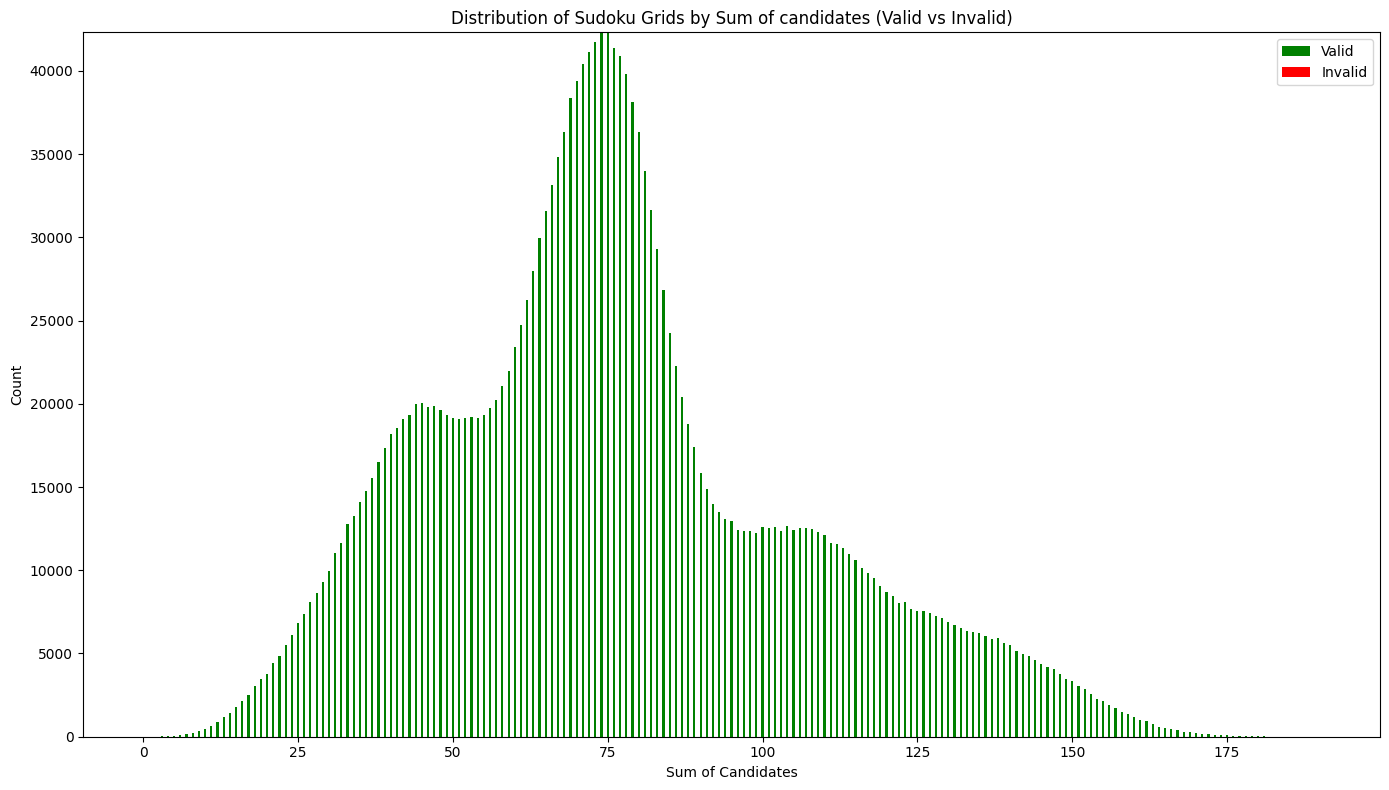

In [10]:
grouped = df.groupby('sum_of_candidates').agg(
    total_count=('sum_of_candidates', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['sum_of_candidates']))

bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Sum of Candidates')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Sum of candidates (Valid vs Invalid)')
plt.legend()

plt.tight_layout()
plt.show()

## Value of number_of_initial_values up to which the relation between this column and number of steps to solve is perfectly linear

In [12]:
df_filtered[df_filtered['number_of_initial_values'] == 81]["number_of_steps_to_solve"].max()

for i in range(81, 0, -1):
    tmp = df_filtered[df_filtered['number_of_initial_values'] == i]["number_of_steps_to_solve"]
    if  tmp.min() != tmp.max():
        print(i)
        break

81


## Valid grids grouped by number_of_initial_values to show their count

In [ ]:
df_filtered.groupby("number_of_initial_values").count()['numbers_of_steps_to_solve']

## Iterative generating subgrids from given grids

In [ ]:
from itertools import combinations
from random import sample

def generate_subsets(grid, n, limit):
    non_zero_indices = [i for i, char in enumerate(grid) if char != '0']
    
    indices_to_remove_combinations = list(combinations(non_zero_indices, n))
    if len(indices_to_remove_combinations) > limit:
        indices_to_remove_combinations = sample(indices_to_remove_combinations, limit)
    
    subsets = []
    for indices in indices_to_remove_combinations:
        subset_list = list(grid)
        for index in indices:
            subset_list[index] = '0'
        subsets.append("".join(subset_list))
    
    return subsets

In [ ]:
def generate_subgrids(grids, outfile, deepness, no_subgrids):
    with open(outfile, 'a') as f:
        for g in grids:
            subsets = generate_subsets(g, deepness, no_subgrids)
            for s in subsets:
                f.write(f"{s}\n")
        

In [ ]:
grids = df[df["is_valid"]].sort_values('number_of_initial_values')[:10]['sudoku']

generate_subgrids(grids, "grids/grids_random.txt", 5, 50000)

# Other

In [2]:
from src.SudokuDB import SudokuDB

file = open("sudoku_db.csv")
db = SudokuDB(file)
value = db.get_sudoku_by_difficulty(2.3)
value

KeyboardInterrupt: 

In [4]:
import os

def find_closest_value_in_file(target_value, file_path='sudoku_db.csv'):
    def get_line(file, line_no):
        file.seek(0)  # Go back to the start of the file
        for _ in range(line_no):
            file.readline()
        return file.readline()
    
    with open(file_path, 'r') as file:
        # Step 1: Count the number of lines
        file.seek(0, os.SEEK_END)
        file_size = file.tell()
        first, last = 0, file_size
        line_count = sum(1 for line in open(file_path))
        
        # Step 2: Binary Search
        while first <= last:
            mid = (first + last) // 2
            file.seek(0)  # Reset to start for each iteration
            mid_line = get_line(file, mid)
            mid_value = float(mid_line.strip().split(',')[-1])
            
            if mid_value == target_value:
                return mid_line.strip()
            elif mid_value < target_value:
                first = mid + 1
            else:
                last = mid - 1

        # If the loop exits, the exact value was not found.
        # We need to decide whether the first or last is closer to the target.
        closer_line = get_line(file, first if abs(float(get_line(file, first).strip().split(',')[-1]) - target_value) < abs(float(get_line(file, last).strip().split(',')[-1]) - target_value) else last)
        return closer_line.strip()

# Example usage
target_value = 5.5
print(find_closest_value_in_file(target_value))

KeyboardInterrupt: 

In [29]:
def get_by_diff(desired_difficulty):
    delta = 10
    choice = None
    with open("sudoku_db.csv") as f:
        f.readline()
        for line in f:
            diff = float(line.split(";")[-1].strip())
            if abs(diff - desired_difficulty) > delta:
                print(diff - desired_difficulty, delta)
                return choice
            
            delta = abs(diff - desired_difficulty)
            choice = line
            
    return choice

In [30]:
desired_difficulty = 2.5
value = get_by_diff(desired_difficulty)

0.08391405792776085 0.08364920021729771


In [31]:
print(value)

821093704350781926607542080986254100073100042412837569040915673069328415100076098;19;62;3.17;20;True;2.5836492002172977



In [28]:
abs(1 - 2.5)

1.5

In [9]:
from src.SudokuDB import SudokuDB

db = SudokuDB()
line = db.get_sudoku_by_diff(9.8)
sudoku_hash = line.split(";")[0]


0.0026297698015387283 0.00081580590765995


In [10]:
sudoku_hash

'000003296000010000300786000000008010006400800805000007790800040000000600002007901'

In [11]:
from src.Sudoku import Sudoku
from src.SudokuAnalyzer import SudokuAnalyzer

sudoku = Sudoku(sudoku_hash)
print(sudoku.str_with_colors())

analyzer = SudokuAnalyzer(sudoku)
analyzer.get_sudoku_description()

0 0 0 0 0 3 2 9 6 
0 0 0 0 1 0 0 0 0 
3 0 0 7 8 6 0 0 0 
0 0 0 0 0 8 0 1 0 
0 0 6 4 0 0 8 0 0 
8 0 5 0 0 0 0 0 7 
7 9 0 8 0 0 0 4 0 
0 0 0 0 0 0 6 0 0 
0 0 2 0 0 7 9 0 1 



(204, 26, 3.04)

In [12]:
with open("output_solver.txt") as f:
    solution = list(f.readlines())


In [14]:
x, y, value = solution[3].split()

In [18]:
value

'3'